In [1]:
from allensdk.core.reference_space_cache import ReferenceSpaceCache

reference_space_key = 'annotation/ccf_2017'
resolution = 25
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest='manifest.json')
# ID 1 is the adult mouse structure graph
tree = rspc.get_structure_tree(structure_graph_id=1) 

/Users/jacobv/jakepy/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/jacobv/jakepy/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [5]:
# now let's take a look at a structure
tree.get_structures_by_name(['Dorsal auditory area'])

[{'acronym': 'AUDd',
  'graph_id': 1,
  'graph_order': 122,
  'id': 1011,
  'name': 'Dorsal auditory area',
  'structure_id_path': [997, 8, 567, 688, 695, 315, 247, 1011],
  'structure_set_ids': [112905828,
   688152357,
   691663206,
   687527945,
   12,
   184527634,
   167587189,
   114512891],
  'rgb_triplet': [1, 147, 153]}]

In [6]:
# get a structure's parent
tree.parents([1011])

[{'acronym': 'AUD',
  'graph_id': 1,
  'graph_order': 121,
  'id': 247,
  'name': 'Auditory areas',
  'structure_id_path': [997, 8, 567, 688, 695, 315, 247],
  'structure_set_ids': [3, 112905828, 691663206, 12, 184527634, 114512891],
  'rgb_triplet': [1, 147, 153]}]

In [8]:
# get a dictionary mapping structure ids to names

name_map = tree.get_name_map()
name_map[247]

'Auditory areas'

In [9]:
name_map

{997: 'root',
 8: 'Basic cell groups and regions',
 567: 'Cerebrum',
 688: 'Cerebral cortex',
 695: 'Cortical plate',
 315: 'Isocortex',
 184: 'Frontal pole, cerebral cortex',
 68: 'Frontal pole, layer 1',
 667: 'Frontal pole, layer 2/3',
 526157192: 'Frontal pole, layer 5',
 526157196: 'Frontal pole, layer 6a',
 526322264: 'Frontal pole, layer 6b',
 500: 'Somatomotor areas',
 107: 'Somatomotor areas, Layer 1',
 219: 'Somatomotor areas, Layer 2/3',
 299: 'Somatomotor areas, Layer 5',
 644: 'Somatomotor areas, Layer 6a',
 947: 'Somatomotor areas, Layer 6b',
 985: 'Primary motor area',
 320: 'Primary motor area, Layer 1',
 943: 'Primary motor area, Layer 2/3',
 648: 'Primary motor area, Layer 5',
 844: 'Primary motor area, Layer 6a',
 882: 'Primary motor area, Layer 6b',
 993: 'Secondary motor area',
 656: 'Secondary motor area, layer 1',
 962: 'Secondary motor area, layer 2/3',
 767: 'Secondary motor area, layer 5',
 1021: 'Secondary motor area, layer 6a',
 1085: 'Secondary motor area, 

In [10]:
# ask whether one structure is contained within another

structure_id_a = 385
structure_id_b = 247

is_desc = '' if tree.structure_descends_from(structure_id_a, structure_id_b) else ' not'
print( '{0} is{1} in {2}'.format(name_map[structure_id_a], is_desc, name_map[structure_id_b]) )

Primary visual area is not in Auditory areas


In [11]:
# build a custom map that looks up acronyms by ids
# the syntax here is just a pair of node-wise functions. 
# The first one returns keys while the second one returns values

acronym_map = tree.value_map(lambda x: x['id'], lambda y: y['acronym'])
print( acronym_map[structure_id_a] )

VISp


## Downloading an annotation volume
You can obtain annotation volumes through the ReferenceSpaceCache which stores a nrrd file containing the Allen Common Coordinate Framework annotation on your hard drive. Above we set the resolution for annotations when we initialized the ReferenceSpaceCache to 25-micron isometric spacing. The orientation of this space is:

* Anterior -> Posterior
* Superior -> Inferior
* Left -> Right

In [12]:
import os

annotation, meta = rspc.get_annotation_volume()
# The file should appear in the reference space key directory
os.listdir(reference_space_key)

2021-04-20 11:52:05,341 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_25.nrrd


['annotation_25.nrrd']

In [13]:
rsp = rspc.get_reference_space()


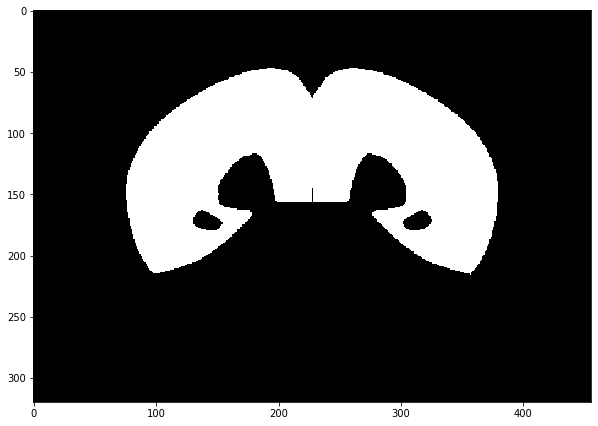

In [17]:
import matplotlib.pyplot as plt

# A complete mask for one structure
whole_cortex_mask = rsp.make_structure_mask([315])

# view in coronal section
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(whole_cortex_mask[150, :], interpolation='none', cmap=plt.cm.afmhot)

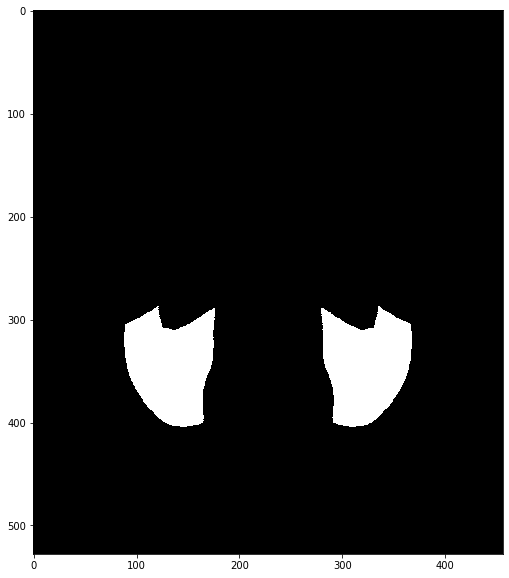

In [21]:
# This gets all of the structures targeted by the Allen Brain Observatory project
brain_observatory_structures = rsp.structure_tree.get_structures_by_set_id([514166994])
brain_observatory_ids = [st['id'] for st in brain_observatory_structures]

brain_observatory_mask = rsp.make_structure_mask(brain_observatory_ids)

# view in horizontal section
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(brain_observatory_mask[:, 40, :], interpolation='none', cmap=plt.cm.afmhot)

In [22]:
import functools
from allensdk.core.reference_space import ReferenceSpace

# Define a wrapper function that will control the mask generation. 
# This one checks for a nrrd file in the specified base directory 
# and builds/writes the mask only if one does not exist
annotation_dir = 'annotation'
mask_writer = functools.partial(ReferenceSpace.check_and_write, annotation_dir)
    
# many_structure_masks is a generator - nothing has actrually been run yet
mask_generator = rsp.many_structure_masks([385, 1097], mask_writer)

# consume the resulting iterator to make and write the masks
for structure_id in mask_generator:
    print( 'made mask for structure {0}.'.format(structure_id) ) 

os.listdir(annotation_dir)

made mask for structure 385.
made mask for structure 1097.


['ccf_2017', 'structure_385.nrrd', 'structure_1097.nrrd']

### Removing unassigned structures
A structure graph may contain structures that are not used in a particular reference space. Having these around can complicate use of the reference space, so we generally want to remove them.

We'll try this using "Somatosensory areas, layer 6a" as a test case. In the 2016 ccf space, this structure is unused in favor of finer distinctions (e.g. "Primary somatosensory area, barrel field, layer 6a").

In [23]:
# Double-check the voxel counts
no_voxel_id = rsp.structure_tree.get_structures_by_name(['Somatosensory areas, layer 6a'])[0]['id']
print( 'voxel count for structure {0}: {1}'.format(no_voxel_id, rsp.total_voxel_map[no_voxel_id]) )

# remove unassigned structures from the ReferenceSpace's StructureTree
rsp.remove_unassigned()

# check the structure tree
no_voxel_id in rsp.structure_tree.node_ids()

voxel count for structure 12997: 0


False

In [74]:
rsp.get_slice_image(1, 4000).shape

(528, 456, 3)

In [75]:
528*456

240768

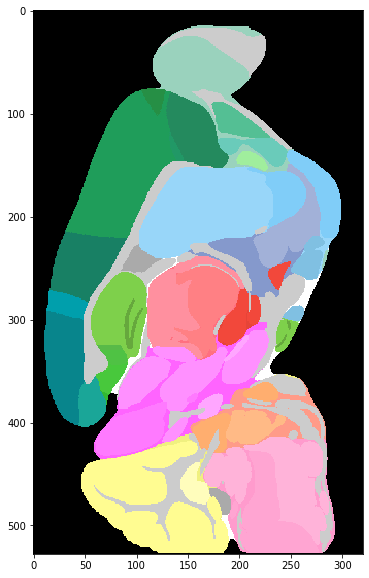

In [70]:
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(rsp.get_slice_image(2, 4000), interpolation='none')

In [80]:
from allensdk.api.queries.rma_api import RmaApi
import pandas as pd
api = RmaApi()


# user input directory name here for saving the files at the end # ages = ['E11.5']
directory='D:\Data\DevelopingAllenMouseAPI-master\Git\Data\\'

ages = ['E11.5','E13.5','E15.5','E18.5','P4','P14','P28']

age_str = "'" + "','".join(ages) + "'"

criteria=['[graph_id$eq17][st_level$eq1][acronym$eqH]'
          #'products[abbreviation$eqDevMouse],'
          #'specimen(donor(age[name$in%s])),' %age_str,
          #'plane_of_section[name$eqsagittal]'
         ]
structure_H=pd.DataFrame(api.model_query('Structure',
                            criteria="".join(criteria),
                            include='descendant_hierarchies(descendant)',
                            start_row=0,
                            num_rows='all'))

In [87]:
# import sys
# print('\n'.join(sys.path))

from allensdk.api.queries.rma_api import RmaApi
import pandas as pd
import os



api = RmaApi()

MOUSE_GRAPH_ID = 17

def getStructureInfo(structure_level, other_criteria):
    STRUCTURE_LEVEL=structure_level
    OTHER_CRITERIA=other_criteria

    structures = pd.DataFrame(
        api.model_query('Structure',
                        criteria=('[graph_id$eq%d]' % MOUSE_GRAPH_ID)+\
                                ('[st_level$eq%d]' % STRUCTURE_LEVEL)+\
                                (str(OTHER_CRITERIA)),
                        num_rows='all'))
    return structures

def getStructureInfo_AdultMouse():
    structures = pd.DataFrame(
        api.model_query('Structure',
                        criteria='[graph_id$eq1]',
                        num_rows='all'))
    return structures

def getCentreCoordinates_DevMouse(structure_level):
    STRUCTURE_LEVEL=structure_level

    structure_centers = pd.DataFrame(
    api.model_query('StructureCenter',
                    criteria='structure'+\
                            ('[st_level$eq%d]' % STRUCTURE_LEVEL)+\
                            ('[graph_id$eq%d]' % MOUSE_GRAPH_ID),
                    num_rows='all'))
    return structure_centers

def getCentreCoordinates_AdultMouse():
    structure_centers_adult = pd.DataFrame(
    api.model_query('StructureCenter',
                    criteria='structure[graph_id$eq1]',
                    num_rows='all'))
    return structure_centers_adult

def getAcronymPath(structure_level, other_criteria):
    STRUCTURE_LEVEL=structure_level
    OTHER_CRITERIA=other_criteria

    OntologyNode = pd.DataFrame(
    api.model_query('OntologyNode',
                    criteria='structure'+\
                            ('[st_level$eq%d]' % STRUCTURE_LEVEL)+\
                            ('[graph_id$eq%d]' % MOUSE_GRAPH_ID)+\
                            (str(OTHER_CRITERIA)),
                    num_rows='all'))
    return OntologyNode

def main():
    print('hi')
    #os.chdir(r'D:\Data\DevelopingAllenMouseAPI-master\Git') # user input the Git directory as on their computer here

    # download level 5 structures of developing mouse
    other_criteria_level5 = '[parent_structure_id$ne126651574]\
                            [parent_structure_id$ne126651586]\
                            [parent_structure_id$ne126651606]\
                            [parent_structure_id$ne126651618]\
                            [parent_structure_id$ne126651642]\
                            [parent_structure_id$ne126651654]\
                            [parent_structure_id$ne126651670]\
                            [parent_structure_id$ne126651682]\
                            [parent_structure_id$ne126651698]\
                            [parent_structure_id$ne126651710]\
                            [parent_structure_id$ne126651730]\
                            [parent_structure_id$ne126651742]\
                            [parent_structure_id$ne126651758]\
                            [parent_structure_id$ne126651770]\
                            [parent_structure_id$ne126651790]\
                            [parent_structure_id$ne126651810]\
                            [parent_structure_id$ne126651830]\
                            [parent_structure_id$ne126651854]\
                            [parent_structure_id$ne126651874]\
                            [parent_structure_id$ne126651898]\
                            [parent_structure_id$ne126651918]\
                            [parent_structure_id$ne126651942]\
                            [parent_structure_id$ne126651962]\
                            [parent_structure_id$ne126651982]\
                            [parent_structure_id$ne126652002]\
                            [parent_structure_id$ne126652022]\
                            [parent_structure_id$ne17651]\
                            [parent_structure_id$ne126652042]'

    structures=getStructureInfo(structure_level=5, other_criteria=other_criteria_level5)

    STRUCTURE_LEVEL = 5

    # specify the directories
    #abs_dir = os.path.dirname(__file__)
    #rel_dir = os.path.join(abs_dir, '..','Data','API','Structures')
    rel_dir = './'
    
    data = os.path.join(rel_dir, 'structureData_level%d.csv' % STRUCTURE_LEVEL)
    structures.to_csv(data)

    # download level 3 structures pf developing mouse
    other_criteria_level3 = '[parent_structure_id$ne126651566]\
                            [parent_structure_id$ne126651634]\
                            [parent_structure_id$ne126651722]\
                            [parent_structure_id$ne126651786]\
                            [parent_structure_id$ne126651850]\
                            [parent_structure_id$ne126651894]\
                            [parent_structure_id$ne126651938]'
    structures=getStructureInfo(structure_level=3, other_criteria=other_criteria_level3)

    STRUCTURE_LEVEL = 3

    data = os.path.join(rel_dir, 'structureData_level%d.csv' % STRUCTURE_LEVEL)
    structures.to_csv(data)

    # download adult mouse structure info
    structures = getStructureInfo_AdultMouse()
    data = os.path.join(rel_dir, 'structureData_adult.csv')
    structures.to_csv(data)

    # Download coordinates of centre of developing mouse structures
    structure_centers=getCentreCoordinates_DevMouse(structure_level=5)
    STRUCTURE_LEVEL = 5
    data = os.path.join(rel_dir, 'structureCenters_level%d.csv' % STRUCTURE_LEVEL)
    structure_centers.to_csv(data)

    # Download coordinates of centre of adult mouse structures
    structure_centers_adult=getCentreCoordinates_AdultMouse()
    data = os.path.join(rel_dir, 'structureCenters_adult.csv')
    structure_centers_adult.to_csv(data)

    # download acronym path for developing mouse
    OntologyNode=getAcronymPath(structure_level=5, other_criteria=other_criteria_level5)
    STRUCTURE_LEVEL = 5
    data = os.path.join(rel_dir, 'AcronymPath_level%d.csv' % STRUCTURE_LEVEL)
    OntologyNode.to_csv(data)

#if __name__ == '__main__':
main()

hi


In [90]:
ls

AMBA_GCorr.ipynb                 README.md
AcronymPath_level5.csv           Regional_Models.ipynb
Brainspan-GCorr.ipynb            Rotating-GCorrected.ipynb
Brainspan.ipynb                  Rotating.ipynb
CCA_GXP.ipynb                    Untitled.ipynb
CCA_GXP_X-GCorrected.ipynb       annotation/
CCA_GXP_X-MouseGenes.ipynb       manifest.json
CCA_GXP_X.ipynb                  render_surface.ipynb
Enrichment.ipynb                 structureCenters_adult.csv
Enrichment_neat.ipynb            structureCenters_level5.csv
Exponentionals-GCorrected.ipynb  structureData_adult.csv
GTEx_IndivCongruence.csv         structureData_level3.csv
GTex_GCorr.ipynb                 structureData_level5.csv
MouseRegions.ipynb               structures.json
PNC_GMCov.ipynb


In [91]:
pandas.read_csv('structureCenters_adult.csv')

,Unnamed: 0,id,reference_space_id,structure_id,x,y,z
0,0,9873,10,304,2960,2700,5430
1,1,10524,9,993,3610,2110,7030
2,2,10774,9,19,4820,2920,5770
3,3,10853,9,338,5870,3410,5790
4,4,9938,10,563807435,8060,3960,3970
...,...,...,...,...,...,...,...
1675,1675,10692,9,350,10620,4700,6660
1676,1676,10691,9,781,11270,4490,7670
1677,1677,10055,10,981,6640,1380,2100
1678,1678,10218,10,269,10090,2170,2390


In [82]:
# extract ID of descendants
descendantID=[]
#only keep those experiments with entrez ID available
for i in range(len(structure_H['descendant_hierarchies'][0])):
    descendantID.append(structure_H['descendant_hierarchies'][0][i].get('descendant_id'))

In [83]:
descendantID

[16808,
 17220,
 17352,
 16809,
 17092,
 17416,
 17156,
 17476,
 16810,
 17290,
 17353,
 17221,
 17093,
 16915,
 17596,
 17538,
 17023,
 17091,
 17539,
 17540,
 17289,
 17182,
 17355,
 16811,
 17157,
 16911,
 17094,
 17291,
 17292,
 17437,
 17095,
 17500,
 17477,
 17351,
 17595,
 17650,
 17155,
 17053,
 17562,
 17478,
 16919,
 17318,
 17219,
 17598,
 17223,
 17158,
 17417,
 17418,
 17222,
 17022,
 16876,
 17620,
 17537,
 17475,
 17354,
 16916,
 16813,
 17380,
 17024,
 16967,
 17250,
 17415,
 17025,
 17597,
 17123,
 111220770,
 111220772,
 112892383,
 17251,
 112892385,
 112892343,
 17066,
 17599,
 112892345,
 111220912,
 111220918,
 111220916,
 17563,
 111220838,
 17196,
 111220840,
 17419,
 17079,
 17581,
 17485,
 17361,
 111220622,
 17612,
 16959,
 112892333,
 112892335,
 17266,
 112892429,
 111220678,
 111220680,
 17096,
 17373,
 111220834,
 17638,
 17036,
 17424,
 111220836,
 17101,
 17275,
 16920,
 111220646,
 17207,
 114403715,
 17571,
 17107,
 17381,
 17170,
 112892323,
 17629,


In [79]:
structures_lev13

,acronym,atlas_id,color_hex_triplet,depth,failed,failed_facet,graph_id,graph_order,hemisphere_id,id,...,neuro_name_structure_id,neuro_name_structure_id_path,ontology_id,parent_structure_id,safe_name,sphinx_id,st_level,structure_id_path,structure_name_facet,weight
0,PaMP,None,E4866F,12,False,734881840,17,688,3,16223,...,None,None,12,16219,medial parvicellular part of PPa,10605,13,/15564/15565/15566/15567/15738/16211/16212/162...,1192503938,8390
1,IntDL,None,F284FF,11,False,734881840,17,1449,3,16931,...,None,None,12,16929,dorsolateral part of Int,11366,13,/15564/15565/16808/16809/16915/16919/16920/169...,664699312,8390
2,PaLM,None,E4866F,12,False,734881840,17,686,3,16221,...,None,None,12,16219,lateral magnocellular part of PPa,10603,13,/15564/15565/15566/15567/15738/16211/16212/162...,3219244292,8390
3,LatPC,None,F284FF,11,False,734881840,17,1453,3,16935,...,None,None,12,16933,parvicellular part of Lat,11370,13,/15564/15565/16808/16809/16915/16919/16920/169...,355155762,8390
4,MedDL,None,F070FF,11,False,734881840,17,1330,3,16826,...,None,None,12,16823,dorsolateral part of Med,11247,13,/15564/15565/16808/16809/16810/16813/16814/168...,3738493123,8390
5,MedM,None,F070FF,11,False,734881840,17,1328,3,16824,...,None,None,12,16823,medial (main) part of Med,11245,13,/15564/15565/16808/16809/16810/16813/16814/168...,316756599,8390
6,Pacap,None,E4866F,12,False,734881840,17,685,3,16220,...,None,None,12,16219,cap part of PPa,10602,13,/15564/15565/15566/15567/15738/16211/16212/162...,1830954800,8390
7,MedL,None,F070FF,11,False,734881840,17,1329,3,16825,...,None,None,12,16823,lateral part of Med,11246,13,/15564/15565/16808/16809/16810/16813/16814/168...,2717973987,8390
8,LatDL,None,F284FF,11,False,734881840,17,1452,3,16934,...,None,None,12,16933,dorsolateral part of Lat,11369,13,/15564/15565/16808/16809/16915/16919/16920/169...,2798477204,8390
9,PaMM,None,E4866F,12,False,734881840,17,687,3,16222,...,None,None,12,16219,medial magnocellular part of PPa,10604,13,/15564/15565/15566/15567/15738/16211/16212/162...,300605474,8390


In [25]:
import matplotlib.pyplot as plot
import seaborn as sns
import numpy as np
import pandas 

In [34]:
df = pandas.read_csv('/Users/jacobv/Downloads/egenes_data.csv',index_col=0)
df.head()

,C1,C2,C3,keep
Blood protein levels,15,1,7,False
Total PHF-tau (SNP x SNP interaction),9,1,0,False
Exploratory eye movement dysfunction in schizophrenia (cognitive search score),2,0,0,True
Weight,2,0,0,True
Metabolite levels,3,0,0,True


<AxesSubplot:>

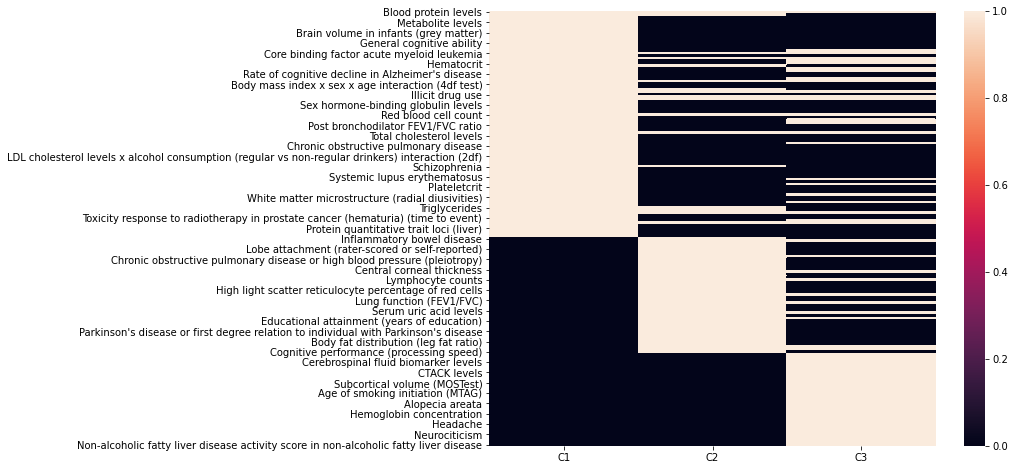

In [33]:
plt.subplots(figsize=(10,8))
sns.heatmap(df,vmax=1)

In [43]:
df[df.keep==True][df.columns[:3]].shape

(128, 3)

In [50]:
sortdf = pandas.concat([df[(df.keep==True) & (df.C1>0)].sort_values('C1',ascending=False),
                      df[(df.keep==True) & (df.C2>0)].sort_values('C2',ascending=False),
                      df[(df.keep==True) & (df.C3>0)].sort_values('C3',ascending=False)])

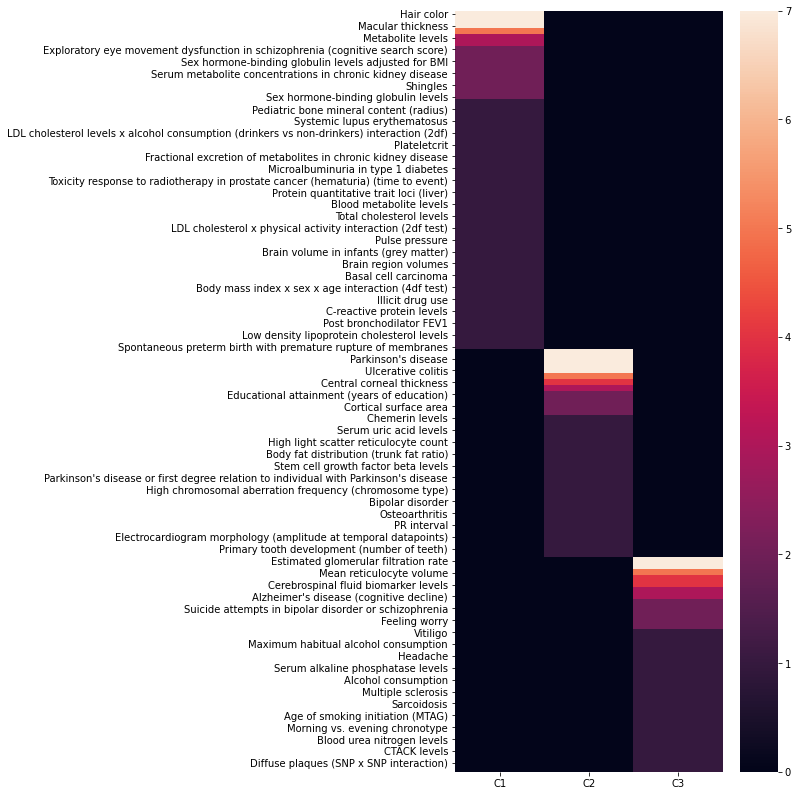

In [59]:
plt.subplots(figsize=(6,14))
sns.heatmap(sortdf[['C1','C2','C3']],vmax=7,)
plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/eQTL_unique.pdf',
           bbox_inches='tight')

<AxesSubplot:>

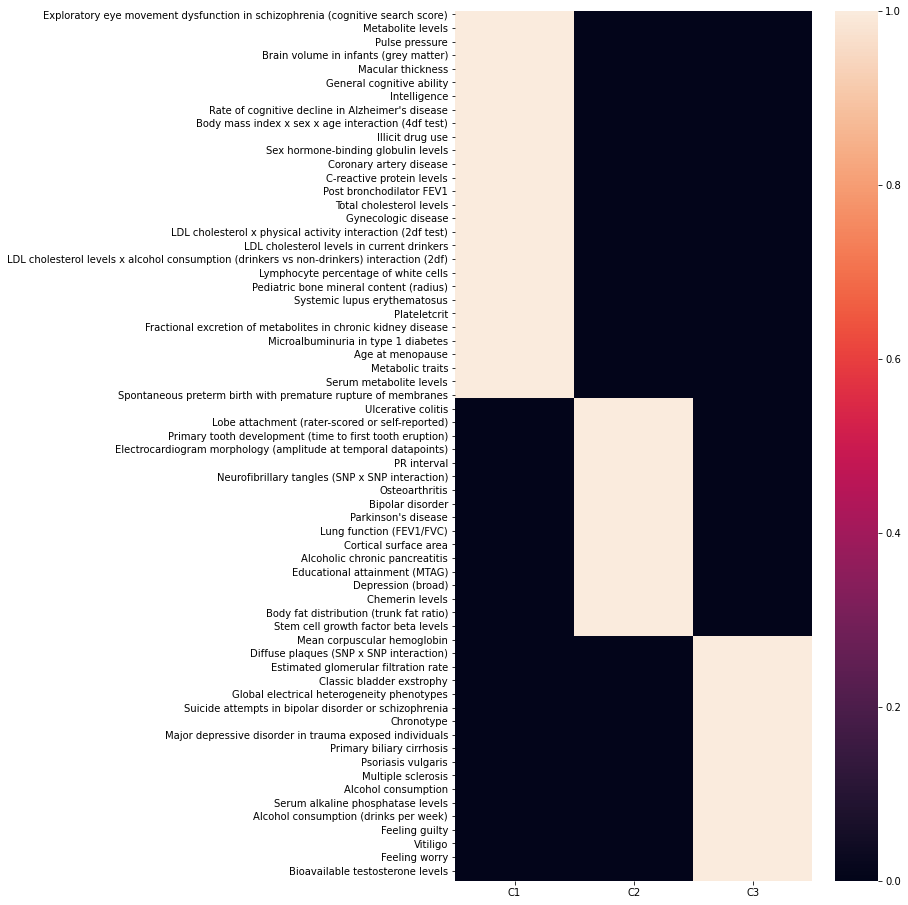

In [45]:
plt.subplots(figsize=(8,16))
sns.heatmap(df[df.keep==True][df.columns[:3]],vmax=1)

In [62]:
df.loc[:,'total_hits'] = df[['C1','C2','C3']].sum(1).values

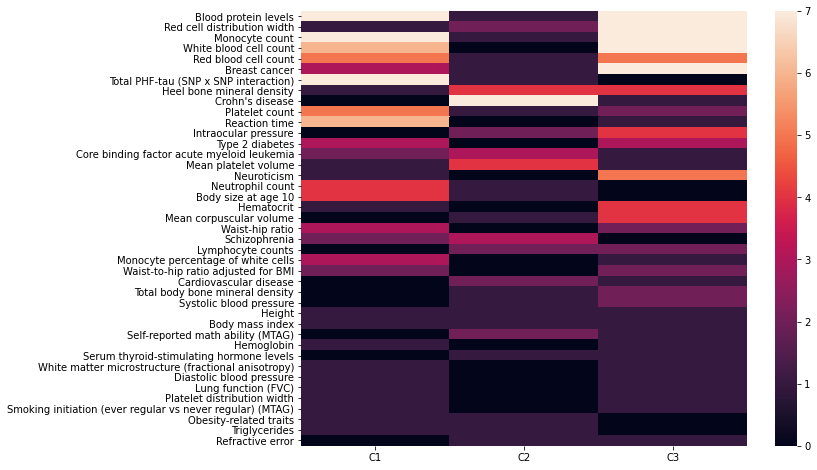

In [68]:
plt.subplots(figsize=(10,8))
sns.heatmap(df[df.keep==False].sort_values('total_hits',ascending=False)[df.columns[:3]],
            vmax=7
           )
plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/eQTL_shared.pdf',
           bbox_inches='tight')